In [1]:
import hopsworks
import joblib
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

2024-10-18 06:52:57,451 INFO: generated new fontManager


In [2]:
project = hopsworks.login()
fs = project.get_feature_store()

2024-10-18 06:53:18,882 INFO: Python Engine initialized.

Logged in to project, explore it here https://demo.hops.works/p/123


In [3]:
feature_view = fs.get_feature_view("fraud_model_stream_fv", 1)

In [4]:
X_train, X_test, y_train, y_test = feature_view.get_train_test_split(1)

In [5]:
X_train

,amount,time_delta_t_minus_1,loc_delta_t_minus_1,is_outside_city,age,cc_expiration_days,count_trans,min_amount,max_amount,avg_amount,label_encoder_category_,label_encoder_cc_provider_,label_encoder_cc_type_
0,2.82,6.0,2214.315812,1.0,81.504110,1230,1.0,395.53,395.53,395.53,4,0,1
1,91.43,6.0,1.241441,1.0,94.586301,1536,1.0,10.93,10.93,10.93,0,1,0
2,97.06,5.0,1076.773341,1.0,45.252055,-200,1.0,58.18,58.18,58.18,4,0,0
3,54.01,0.0,1310.708160,1.0,54.939726,14,1.0,54.60,54.60,54.60,5,0,1
4,92.74,0.0,3537.225716,1.0,91.172603,1505,1.0,4.70,4.70,4.70,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66015,96.49,6.0,4636.870309,1.0,27.504110,744,1.0,80.93,80.93,80.93,4,0,1
66016,16.01,5.0,3201.028931,1.0,66.410959,591,1.0,217.41,217.41,217.41,0,0,1
66017,67.47,0.0,882.317966,1.0,96.854795,287,1.0,8.09,8.09,8.09,4,1,0
66018,7.67,0.0,4013.618272,1.0,65.835616,1567,1.0,51.62,51.62,51.62,8,1,0


In [6]:
# Create an instance of the XGBClassifier
clf = xgb.XGBClassifier()

# Fit the classifier on the training data
clf.fit(X_train.values, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [7]:
# Predict the training data using the trained classifier
y_pred_train = clf.predict(X_train.values)

# Predict the test data using the trained classifier
y_pred_test = clf.predict(X_test.values)

In [8]:
# Compute f1 score
metrics = {
    "f1_score": f1_score(y_test, y_pred_test, average='macro')
}
metrics

{'f1_score': 0.49966920277869664}

In [9]:
# Generate the confusion matrix using the true labels (y_test) and predicted labels (y_pred_test)
results = confusion_matrix(y_test, y_pred_test)

# Print the confusion matrix
print(results)

[[3021    0]
 [   4    0]]


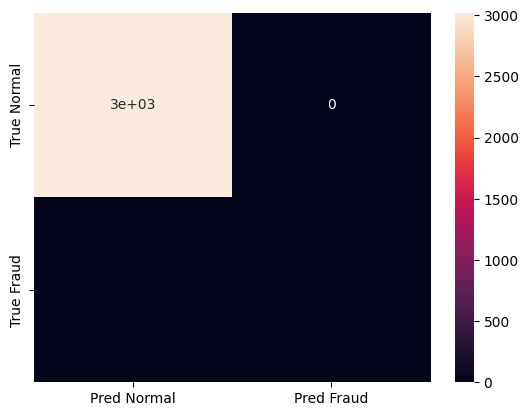

In [10]:
# Create a DataFrame from the confusion matrix results with appropriate labels
df_cm = pd.DataFrame(
    results, 
    ['True Normal', 'True Fraud'],
    ['Pred Normal', 'Pred Fraud'],
)

# Create a heatmap using seaborn with annotations
cm = sns.heatmap(df_cm, annot=True)

# Get the figure from the heatmap and display it
fig = cm.get_figure()
fig

In [11]:
# Specify the directory where the model will be saved
model_dir = "fraud_model"

# Check if the directory exists, and create it if it doesn't
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

# Save the trained XGBoost model using joblib
joblib.dump(clf, model_dir + '/xgboost_fraud_model.pkl')

# Save the confusion matrix heatmap as an image in the model directory
images_dir = f"{model_dir}/images"
if not os.path.isdir(images_dir):
    os.mkdir(images_dir)
fig.savefig(images_dir + "/confusion_matrix.png")

In [12]:
# Get the model registry
mr = project.get_model_registry()

# Create a new model in the model registry
fraud_model = mr.python.create_model(
    name="xgboost_fraud_model",  # Name for the model
    version=2,
    description="Fraud Predictor",        # Description of the model
    metrics=metrics,                      # Metrics used for evaluation,
    feature_view=feature_view,
    training_dataset_version=1,
)

# Save the model to the specified directory
fraud_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://demo.hops.works/p/123/models/xgboost_fraud_model/2


Model(name: 'xgboost_fraud_model', version: 2)